# This is implimentation of "Knowledge Neurons in Pretrained Transformers"
by Damai Dai, Li Dong, Yaru Hao, Zhifang Sui, Baobao Chang, Furu Wei" 

* dependencies to be installed are : torch, transformers version 4.12.5 , jsonlines

## to calculate the Attribution Scores run the following command

In [ ]:
!bash 1_run_mlm.sh param1

* where param1 is the relation name to analyze, such as "P101". You can run this command for each of the 34 relations. This command will calculate the attribution scores for all the facts.

## to identify Knowledge Neurons run the following command

In [ ]:
!bash 2_run_kn.sh.

* This command will identify and refine knowledge neurons for each fact, and give their statistics along with a figure about the knowledge neuron distribution.

## to Modify Knowledge Neurons run the following command

In [ ]:
!bash 3_run_modify_activation.sh

* This command will modify the activation values of knowledge neurons and record the corresponding results.

## to Check Knowledge Neuron Activation for Prompts run the following command

In [ ]:
!bash 4_run_distant.sh

* This command will check the activation values of knowledge neurons for different types of prompts crawled from web pages.(this takes 3 days for all relatoin types)

## to Plot Figures

In [ ]:
!bash 8_run_plot.sh

* This command will plot two figures that visualize the results from 3_run_modify_activation.sh and 4_run_distant.sh

# Model  used

In [2]:
import logging
import argparse
import math
import os
import torch
import random
import numpy as np
import json, jsonlines
import pickle
import time

import transformers
from transformers import BertTokenizer
from custom_bert import BertForMaskedLM
import torch.nn.functional as F
#from ..project.knowledge_neurons.src.custom_bert import BertForMaskedLM

/home/chandan/anaconda3/envs/NLP2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [7]:

tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)
model = BertForMaskedLM.from_pretrained('bert-base-cased')
model = model.to(device)
model

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
          

In [43]:
#an example of a input prompt, expected output and it's relation type
eval_bag_list_perrel['P101'][0]

[['Alan Turing works in the field of [MASK].', 'logic', 'P101(field of work)'],
 ['Alan Turing specializes in [MASK].', 'logic', 'P101(field of work)'],
 ['[MASK] is the specialization of Alan Turing.',
  'logic',
  'P101(field of work)'],
 ['The expertise of Alan Turing is [MASK].', 'logic', 'P101(field of work)'],
 ['[MASK] is the expertise of Alan Turing.', 'logic', 'P101(field of work)'],
 ['The domain of activity of Alan Turing is [MASK].',
  'logic',
  'P101(field of work)'],
 ['The domain of work of Alan Turing is [MASK].',
  'logic',
  'P101(field of work)'],
 ['[MASK] is the domain of activity of Alan Turing.',
  'logic',
  'P101(field of work)'],
 ["Alan Turing's area of work is [MASK].", 'logic', 'P101(field of work)'],
 ["Alan Turing's domain of work is [MASK].", 'logic', 'P101(field of work)'],
 ["Alan Turing's domain of activity is [MASK].",
  'logic',
  'P101(field of work)'],
 ["Alan Turing's expertise is [MASK].", 'logic', 'P101(field of work)'],
 ['Alan Turing works i

# Analysing model for knowledge neuron

In [20]:
import jsonlines, json
import numpy as np
from collections import Counter
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns

import random

import pandas as pd
from pandas.core.frame import DataFrame

In [2]:
threshold_ratio = 0.2
mode_ratio_bag = 0.7
mode_ratio_rel = 0.1
kn_dir = '/home/chandan/NLP/project/knowledge_neurons/results/kn'
rlts_dir = '/home/chandan/NLP/project/knowledge_neurons/results'

In [3]:
def re_filter(metric_triplets):
    metric_max = -999
    for i in range(len(metric_triplets)):
        metric_max = max(metric_max, metric_triplets[i][2])
    metric_triplets = [triplet for triplet in metric_triplets if triplet[2] >= metric_max * threshold_ratio]
    return metric_triplets


def pos_list2str(pos_list):
    return '@'.join([str(pos) for pos in pos_list])


def pos_str2list(pos_str):
    return [int(pos) for pos in pos_str.split('@')]


def parse_kn(pos_cnt, tot_num, mode_ratio, min_threshold=0):
    mode_threshold = tot_num * mode_ratio
    mode_threshold = max(mode_threshold, min_threshold)
    kn_bag = []
    for pos_str, cnt in pos_cnt.items():
        if cnt >= mode_threshold:
            kn_bag.append(pos_str2list(pos_str))
    return kn_bag


def analysis_file(filename, metric='ig_gold'):
    rel = filename.split('.')[0].split('-')[-1]
    print(f'===========> parsing important position in {rel}..., mode_ratio_bag={mode_ratio_bag}')

    rlts_bag_list = []
    with open(os.path.join(rlts_dir, filename), 'r') as fr:
        for rlts_bag in jsonlines.Reader(fr):
            rlts_bag_list.append(rlts_bag)

    ave_kn_num = 0

    kn_bag_list = []
    # get imp pos by bag_ig
    for bag_idx, rlts_bag in enumerate(rlts_bag_list):
        pos_cnt_bag = Counter()
        for rlt in rlts_bag:
            res_dict = rlt[1]
            metric_triplets = re_filter(res_dict[metric])
            for metric_triplet in metric_triplets:
                pos_cnt_bag.update([pos_list2str(metric_triplet[:2])])
        kn_bag = parse_kn(pos_cnt_bag, len(rlts_bag), mode_ratio_bag, 3)
        ave_kn_num += len(kn_bag)
        kn_bag_list.append(kn_bag)

    ave_kn_num /= len(rlts_bag_list)

    # get imp pos by rel_ig
    pos_cnt_rel = Counter()
    for kn_bag in kn_bag_list:
        for kn in kn_bag:
            pos_cnt_rel.update([pos_list2str(kn)])
    kn_rel = parse_kn(pos_cnt_rel, len(kn_bag_list), mode_ratio_rel)

    return ave_kn_num, kn_bag_list, kn_rel


def stat(data, pos_type, rel):
    if pos_type == 'kn_rel':
        print(f'{rel}\'s {pos_type} has {len(data)} imp pos. ')
        return
    ave_len = 0
    for kn_bag in data:
        ave_len += len(kn_bag)
    ave_len /= len(data)
    print(f'{rel}\'s {pos_type} has on average {ave_len} imp pos. ')


In [11]:
if not os.path.exists(kn_dir):
    os.makedirs(kn_dir)
for filename in os.listdir(rlts_dir):
    if filename.endswith('.rlt.jsonl'):
        threshold_ratio = 0.2
        mode_ratio_bag = 0.7
        for max_it in range(6):
            ave_kn_num, kn_bag_list, kn_rel = analysis_file(filename)
            if ave_kn_num < 2:
                mode_ratio_bag -= 0.05
            if ave_kn_num > 5:
                mode_ratio_bag += 0.05
            if ave_kn_num >= 2 and ave_kn_num <= 5:
                break
        rel = filename.split('.')[0].split('-')[-1]
        stat(kn_bag_list, 'kn_bag', rel)
        stat(kn_rel, 'kn_rel', rel)
        with open(os.path.join(kn_dir, f'kn_bag-{rel}.json'), 'w') as fw:
            json.dump(kn_bag_list, fw, indent=2)
        with open(os.path.join(kn_dir, f'kn_rel-{rel}.json'), 'w') as fw:
            json.dump(kn_rel, fw, indent=2)

        threshold_ratio = 0.5
        mode_ratio_bag = 0.7
        for max_it in range(6):
            ave_kn_num, kn_bag_list, kn_rel = analysis_file(filename, 'base')
            if ave_kn_num < 2:
                mode_ratio_bag -= 0.05
            if ave_kn_num > 5:
                mode_ratio_bag += 0.05
            if ave_kn_num >= 2 and ave_kn_num <= 5:
                break
        rel = filename.split('.')[0].split('-')[-1]
        stat(kn_bag_list, 'kn_bag', rel)
        stat(kn_rel, 'kn_rel', rel)
        with open(os.path.join(kn_dir, f'base_kn_bag-{rel}.json'), 'w') as fw:
            json.dump(kn_bag_list, fw, indent=2)
        with open(os.path.join(kn_dir, f'base_kn_rel-{rel}.json'), 'w') as fw:
            json.dump(kn_rel, fw, indent=2)

===========> parsing important position in P20..., mode_ratio_bag=0.7


P20's kn_bag has on average 4.906610703043022 imp pos. 
P20's kn_rel has 12 imp pos. 
===========> parsing important position in P20..., mode_ratio_bag=0.7
===========> parsing important position in P20..., mode_ratio_bag=0.75
===========> parsing important position in P20..., mode_ratio_bag=0.8
P20's kn_bag has on average 3.7240293809024134 imp pos. 
P20's kn_rel has 8 imp pos. 
===========> parsing important position in P101..., mode_ratio_bag=0.7
P101's kn_bag has on average 2.5344827586206895 imp pos. 
P101's kn_rel has 5 imp pos. 
===========> parsing important position in P101..., mode_ratio_bag=0.7
P101's kn_bag has on average 4.748563218390805 imp pos. 
P101's kn_rel has 6 imp pos. 
===========> parsing important position in P37..., mode_ratio_bag=0.7
===========> parsing important position in P37..., mode_ratio_bag=0.75
===========> parsing important position in P37..., mode_ratio_bag=0.8
P37's kn_bag has on average 4.286749482401656 imp pos. 
P37's kn_rel has 10 imp pos. 
===

In [8]:
kn_dir = '/home/chandan/NLP/project/knowledge_neurons/results'
fig_dir = '/home/chandan/NLP/project/knowledge_neurons/results/figs/'

In [13]:
# =========== stat kn_bag ig ==============

y_points = []
tot_bag_num = 0
tot_rel_num = 0
tot_kneurons = 0
kn_bag_counter = Counter()
for filename in os.listdir(kn_dir):
    if not filename.startswith('kn_bag-'):
        continue
    with open(os.path.join(kn_dir, filename), 'r') as f:
        kn_bag_list = json.load(f)
        for kn_bag in kn_bag_list:
            for kn in kn_bag:
                kn_bag_counter.update([kn[0]])
                y_points.append(kn[0])
        tot_bag_num += len(kn_bag_list)
for k, v in kn_bag_counter.items():
    tot_kneurons += kn_bag_counter[k]
for k, v in kn_bag_counter.items():
    kn_bag_counter[k] /= tot_kneurons

# average # Kneurons
print('average ig_kn', tot_kneurons / tot_bag_num)

average ig_kn 4.305205479452055


In [14]:
# =========== stat kn_bag base ==============

tot_bag_num = 0
tot_rel_num = 0
tot_kneurons = 0
base_kn_bag_counter = Counter()
for filename in os.listdir(kn_dir):
    if not filename.startswith('base_kn_bag-'):
        continue
    with open(os.path.join(kn_dir, filename), 'r') as f:
        kn_bag_list = json.load(f)
        for kn_bag in kn_bag_list:
            for kn in kn_bag:
                base_kn_bag_counter.update([kn[0]])
        tot_bag_num += len(kn_bag_list)
for k, v in base_kn_bag_counter.items():
    tot_kneurons += base_kn_bag_counter[k]
for k, v in base_kn_bag_counter.items():
    base_kn_bag_counter[k] /= tot_kneurons
# average # Kneurons
print('average base_kn', tot_kneurons / tot_bag_num)

average base_kn 3.898447488584475


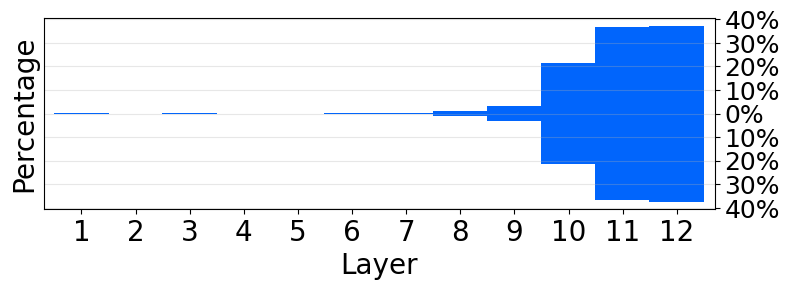

In [18]:
# =========== plot knowledge neuron distribution ===========

plt.figure(figsize=(8, 3))

x = np.array([i + 1 for i in range(12)])
y = np.array([kn_bag_counter[i] for i in range(12)])
plt.xlabel('Layer', fontsize=20)
plt.ylabel('Percentage', fontsize=20)
plt.xticks([i + 1 for i in range(12)], labels=[i + 1 for i in range(12)], fontsize=20)
plt.yticks(np.arange(-0.4, 0.5, 0.1), labels=[f'{np.abs(i)}%' for i in range(-40, 50, 10)], fontsize=18)
plt.tick_params(axis="y", left=False, right=True, labelleft=False, labelright=True, rotation=0, labelsize=18)
plt.ylim(-y.max() - 0.03, y.max() + 0.03)
plt.xlim(0.3, 12.7)
bottom = -y
y = y * 2
plt.bar(x, y, width=1.02, color='#0165fc', bottom=bottom)
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()

#plt.savefig(os.path.join(fig_dir, 'kneurons_distribution.pdf'), dpi=100)
plt.show()
plt.close()

In [19]:
# ========================================================================================
#                       knowledge neuron intersection analysis
# ========================================================================================


def pos_list2str(pos_list):
    return '@'.join([str(pos) for pos in pos_list])


def pos_str2list(pos_str):
    return [int(pos) for pos in pos_str.split('@')]


def cal_intersec(kn_bag_1, kn_bag_2):
    kn_bag_1 = set(['@'.join(map(str, kn)) for kn in kn_bag_1])
    kn_bag_2 = set(['@'.join(map(str, kn)) for kn in kn_bag_2])
    return len(kn_bag_1.intersection(kn_bag_2))

In [20]:
# ====== load ig kn =======

kn_bag_list_per_rel = {}
for filename in os.listdir(kn_dir):
    if not filename.startswith('kn_bag-'):
        continue
    with open(os.path.join(kn_dir, filename), 'r') as f:
        kn_bag_list = json.load(f)
    rel = filename.split('.')[0].split('-')[1]
    kn_bag_list_per_rel[rel] = kn_bag_list

# ig inner
inner_ave_intersec = []
for rel, kn_bag_list in kn_bag_list_per_rel.items():
    print(f'calculating {rel}')
    len_kn_bag_list = len(kn_bag_list)
    for i in range(0, len_kn_bag_list):
        for j in range(i + 1, len_kn_bag_list):
            kn_bag_1 = kn_bag_list[i]
            kn_bag_2 = kn_bag_list[j]
            num_intersec = cal_intersec(kn_bag_1, kn_bag_2)
            inner_ave_intersec.append(num_intersec)
inner_ave_intersec = np.array(inner_ave_intersec).mean()
print(f'ig kn has on average {inner_ave_intersec} inner kn interseciton')

calculating P19
calculating P20
calculating P279
calculating P413
calculating P37
calculating P101
ig kn has on average 1.0279874825689979 inner kn interseciton


In [21]:
# ig inter
inter_ave_intersec = []
for rel, kn_bag_list in kn_bag_list_per_rel.items():
    print(f'calculating {rel}')
    len_kn_bag_list = len(kn_bag_list)
    for i in range(0, len_kn_bag_list):
        for j in range(0, 100):
            kn_bag_1 = kn_bag_list[i]
            other_rel = random.choice([x for x in kn_bag_list_per_rel.keys() if x != rel])
            other_idx = random.randint(0, len(kn_bag_list_per_rel[other_rel]) - 1)
            kn_bag_2 = kn_bag_list_per_rel[other_rel][other_idx]
            num_intersec = cal_intersec(kn_bag_1, kn_bag_2)
            inter_ave_intersec.append(num_intersec)
inter_ave_intersec = np.array(inter_ave_intersec).mean()
print(f'ig kn has on average {inter_ave_intersec} inter kn interseciton')

calculating P19
calculating P20
calculating P279
calculating P413
calculating P37
calculating P101
ig kn has on average 0.043254794520547944 inter kn interseciton


In [22]:
# ====== load base kn =======
kn_bag_list_per_rel = {}
for filename in os.listdir(kn_dir):
    if not filename.startswith('base_kn_bag-'):
        continue
    with open(os.path.join(kn_dir, filename), 'r') as f:
        kn_bag_list = json.load(f)
    rel = filename.split('.')[0].split('-')[1]
    kn_bag_list_per_rel[rel] = kn_bag_list

In [23]:
# base inner
inner_ave_intersec = []
for rel, kn_bag_list in kn_bag_list_per_rel.items():
    print(f'calculating {rel}')
    len_kn_bag_list = len(kn_bag_list)
    for i in range(0, len_kn_bag_list):
        for j in range(i + 1, len_kn_bag_list):
            kn_bag_1 = kn_bag_list[i]
            kn_bag_2 = kn_bag_list[j]
            num_intersec = cal_intersec(kn_bag_1, kn_bag_2)
            inner_ave_intersec.append(num_intersec)
inner_ave_intersec = np.array(inner_ave_intersec).mean()
print(f'base kn has on average {inner_ave_intersec} inner kn interseciton')

calculating P279
calculating P19
calculating P37
calculating P413
calculating P101
calculating P20
base kn has on average 2.750908750115414 inner kn interseciton


In [24]:
# base inter
inter_ave_intersec = []
for rel, kn_bag_list in kn_bag_list_per_rel.items():
    print(f'calculating {rel}')
    len_kn_bag_list = len(kn_bag_list)
    for i in range(0, len_kn_bag_list):
        for j in range(0, 100):
            kn_bag_1 = kn_bag_list[i]
            other_rel = random.choice([x for x in kn_bag_list_per_rel.keys() if x != rel])
            other_idx = random.randint(0, len(kn_bag_list_per_rel[other_rel]) - 1)
            kn_bag_2 = kn_bag_list_per_rel[other_rel][other_idx]
            num_intersec = cal_intersec(kn_bag_1, kn_bag_2)
            inter_ave_intersec.append(num_intersec)
inter_ave_intersec = np.array(inter_ave_intersec).mean()
print(f'base kn has on average {inter_ave_intersec} inter kn interseciton')

calculating P279
calculating P19
calculating P37
calculating P413
calculating P101
calculating P20
base kn has on average 2.080792694063927 inter kn interseciton
